In [18]:
import mysql.connector
import os
import pandas as pd
import numpy as np
from itertools import islice
import tracemalloc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# Begin tracking memory allocation
tracemalloc.start()

In [20]:
# Connection info
host = os.environ["UAT_host"]
db = os.environ["UAT_db"]
port = 3306
user = os.environ["UAT_write_user"]
password = os.environ["UAT_write_password"]

In [21]:
# Open connection
db_conn = mysql.connector.connect(host=host, db=db, port=port, user=user,
                                  passwd=password)
crsr = db_conn.cursor()

In [22]:
# Drop/create table
create_table = """
CREATE TABLE test_connector (
    col_0   INT PRIMARY KEY,
    col_1   FLOAT,
    col_2   FLOAT,
    col_3   FLOAT,
    col_4   FLOAT,
    col_5   FLOAT,
    col_6   FLOAT,
    col_7   FLOAT,
    col_8   FLOAT,
    col_9   FLOAT
);
"""
crsr.execute("DROP TABLE IF EXISTS test_connector;")
crsr.execute(create_table)

In [23]:
# Set a rollback point
crsr.execute("START TRANSACTION;")

In [24]:
# Build a dataframe of 100,000 entries
size = 100000
df = pd.DataFrame(data={
    f"col_{x}": np.random.random(size) for x in range(1, 10)
})
df = df.reset_index().rename(columns={"index": "col_0"})
columns = list(df.columns)

In [25]:
def grouper(n, iterable):
    """Yields an iterable in chunks of even size, with the last chunk
    containing whatever is left."""
    it = iter(iterable)
    while True:
        chunk = tuple(islice(it, n))
        if not chunk:
            return
        yield chunk

In [26]:
# Prepare SQL Insert Statement
field_values = ', '.join(columns)
placeholders = f"({', '.join(['%s' for _ in columns])})"
insert_statement = f"""
INSERT INTO test_connector
({field_values})
VALUES {placeholders};
"""

In [27]:
# Prepare to catch data
target = "mysql/connector/connection_cext.py"
target_line = 514
results = []

In [28]:
def snap_and_report(target, target_line, snapshot_name, verbose=True):
    """Function takes a snapshot of memory allocation and reports target 
    results"""
    file_name = ""
    line_number = 0
    size = 0
    size_in_mb = 0
    count = 0
    snapshot = tracemalloc.take_snapshot()
    top_stats = snapshot.statistics('lineno')
    for stat in top_stats:
        frame = stat.traceback[0]
        if target in frame.filename and frame.lineno == target_line:
            file_name = os.sep.join(frame.filename.split(os.sep)[-3:])
            line_number = frame.lineno
            size = top_stats[0].size
            size_in_mb = size / 1024 ** 2
            count = top_stats[0].count
            break
    if verbose:
        print(f"snapshot: {snapshot_name}")
        print(f"{file_name}:{line_number} | size={size_in_mb:3.2f} MiB "
              f"| count={count}")
    return snapshot_name, file_name, line_number, size, count

In [29]:
results.append(snap_and_report(target, target_line, "prior_to_inserts"))
chunk_size = 10000
for c, chunk in enumerate(grouper(chunk_size, df.itertuples(index=False)), 1):
    values = [[getattr(row, col)
               for col in columns]
              for row in chunk]
    snapshot0 = tracemalloc.take_snapshot()
    crsr.executemany(insert_statement, values)
    results.append(snap_and_report(target, target_line, f"after_insert_{c}"))

snapshot: prior_to_inserts
mysql/connector/connection_cext.py:514 | size=188.63 MiB | count=3000007
snapshot: after_insert_1
mysql/connector/connection_cext.py:514 | size=207.47 MiB | count=3300010
snapshot: after_insert_2
mysql/connector/connection_cext.py:514 | size=226.34 MiB | count=3600010
snapshot: after_insert_3
mysql/connector/connection_cext.py:514 | size=245.20 MiB | count=3900010
snapshot: after_insert_4
mysql/connector/connection_cext.py:514 | size=264.07 MiB | count=4200010
snapshot: after_insert_5
mysql/connector/connection_cext.py:514 | size=282.94 MiB | count=4500010
snapshot: after_insert_6
mysql/connector/connection_cext.py:514 | size=301.80 MiB | count=4800010
snapshot: after_insert_7
mysql/connector/connection_cext.py:514 | size=320.67 MiB | count=5100010
snapshot: after_insert_8
mysql/connector/connection_cext.py:514 | size=339.53 MiB | count=5400010
snapshot: after_insert_9
mysql/connector/connection_cext.py:514 | size=358.40 MiB | count=5700010
snapshot: after_in

In [30]:
# Commit
crsr.execute("COMMIT;")
results.append(snap_and_report(target, target_line, f"after_commit"))

snapshot: after_commit
mysql/connector/connection_cext.py:514 | size=377.27 MiB | count=6000009


In [31]:
# Close Cursor
crsr.close()
results.append(snap_and_report(target, target_line, f"after_cursor_close"))

snapshot: after_cursor_close
mysql/connector/connection_cext.py:514 | size=377.27 MiB | count=6000007


In [32]:
# Close connection
db_conn.close()
results.append(snap_and_report(target, target_line, f"after_connection_close"))

snapshot: after_connection_close
mysql/connector/connection_cext.py:514 | size=377.27 MiB | count=6000007


In [33]:
# Del connection
del db_conn
results.append(snap_and_report(target, target_line, f"after_del_connection"))

snapshot: after_del_connection
mysql/connector/connection_cext.py:514 | size=377.27 MiB | count=6000007


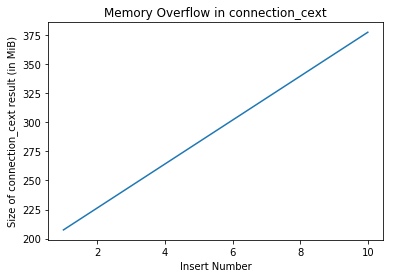

In [34]:
# Plot Results
results_df = pd.DataFrame(results, 
                          columns=["action", "file_name",
                                   "line_number", "size", "count"])
results_df["size_in_mib"] = results_df["size"] / 1024 **2
results_df["action_number"] = results_df.index

sns.lineplot(x="action_number", y="size_in_mib",
             data=results_df.loc[results_df["action"].str.contains(
                 "after_insert_")])
plt.title("Memory Overflow in connection_cext")
plt.xlabel("Insert Number")
plt.ylabel("Size of connection_cext result (in MiB)")
plt.show()